In [73]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
from feature_extraction import OCR_raw_data, OCR_feature_data, face_raw_data, face_feature_data

Two-Layer Neural Network on digit OCR and Face Detection

In [81]:
class TwoLayerNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size+1
        self.hidden_size = hidden_size+1
        self.output_size = output_size
        W1 = np.random.randn(self.hidden_size-1, self.input_size)
        W1 = W1.flatten()
        W2 = np.random.randn(self.output_size, self.hidden_size)
        W2 = W2.flatten()
        self.weights = np.concatenate((W1,W2))
        b1 = np.ones((self.hidden_size,))
        b2 = np.ones((self.output_size,))
        self.biases = np.concatenate((b1,b2))
        L1_grads = np.zeros((self.hidden_size-1, self.input_size))
        L2_grads = np.zeros((self.output_size, self.hidden_size))
        self.gradients = np.concatenate((L1_grads.flatten(),L2_grads.flatten()))
    
    def forward_propagation(self, X):
        W1 = np.reshape(self.weights[0:self.input_size*(self.hidden_size-1)],(self.hidden_size-1,self.input_size))
        W2 = np.reshape(self.weights[self.input_size*(self.hidden_size-1):],(self.output_size,self.hidden_size))
        b1 = self.biases[0: self.hidden_size]
        b2 = self.biases[self.hidden_size:]
        # First layer
        A1 = np.insert(X, 0, 1, axis=0)
        Z2 = np.dot(W1, A1)
        A2 = self.sigmoid(Z2)
        # Second layer
        A2 = np.insert(A2, 0, 1, axis=0)
        Z3 = np.dot(W2, A2)
        A3 = self.sigmoid(Z3)
        
        cache = {"Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3, "A1": A1}
        
        return A3, cache
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def backward_propagation(self, Y, cache):
        W2 = np.reshape(self.weights[self.input_size*(self.hidden_size-1):],(self.output_size,self.hidden_size))
        A1 = cache["A1"]
        A2 = cache["A2"]
        A3 = cache["A3"]
        y=np.array(Y)
        encode_Y = np.eye(self.output_size)[y.astype(int)]
        dZ3 = A3 - encode_Y
        dZ2 = np.dot(W2.T, dZ3) * (A2 * (1 - A2))
        bottomdZ2 = dZ2[1:]
        L1_grads = np.reshape(self.gradients[0:(self.hidden_size-1)*self.input_size],(self.hidden_size-1,self.input_size))
        L1_grads += bottomdZ2[:, np.newaxis] * A1
        L2_grads = np.reshape(self.gradients[(self.hidden_size-1)*self.input_size:],(self.output_size,self.hidden_size))
        L2_grads += dZ3[:, np.newaxis] * A2
        grads = [L1_grads, L2_grads]
        return grads    
    def update_parameters(self,grads, learning_rate, n):
        W1 = np.reshape(self.weights[0:self.input_size*(self.hidden_size-1)],(self.hidden_size-1,self.input_size))
        W2 = np.reshape(self.weights[self.input_size*(self.hidden_size-1):],(self.output_size,self.hidden_size))
        b1 = self.biases[0]
        b2 = self.biases[1]

        L1_grads = grads[0]
        L2_grads = grads[1]

        dW1 = (L1_grads/n) 
        dW1[:,:-1]+= 0.01*(W1[:,:-1])

        dW2 = (L2_grads/n) 
        dW2[:,:-1] += 0.01*(W2[:,:-1])

        W1 -= learning_rate * dW1
        W2 -= learning_rate * dW2
        #b1 -= learning_rate * dW1
        #b2 -= learning_rate * dW2


        self.weights = np.concatenate((W1.flatten(),W2.flatten()))
        self.biases[0] = b1
        self.biases[1] = b2
        self.gradients = np.concatenate((L1_grads.flatten(),L2_grads.flatten()))
    
    def fit(self, X, Y, learning_rate):
        n = len(Y)
        correct = 0
        self.gradients = np.zeros(self.gradients.shape)    
        for j in range(X.shape[0]):

            x = X[j]
            y = Y[j]
            A3, cache = self.forward_propagation(x)
            if self.output_size == 2:
                if A3[1] > 0.5:
                    prediction = 1
                else:
                    prediction = 0
                if prediction == y:
                    correct += 1
                    continue
            else:
                if np.argmax(A3) == y:
                    correct += 1
                    continue
            
            grads= self.backward_propagation(y, cache)
            
            self.update_parameters(grads, learning_rate,n)
        #print("Iteration: ", i, "Accuracy: ", correct/n)
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtracting max(x) for numerical stability
        return exp_x / exp_x.sum(axis=0)

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            x = X[i]
            A3, _ = self.forward_propagation(x)
            if self.output_size == 2:
                if A3[1] > 0.5:
                    prediction = 1
                else:
                    prediction = 0
            else:
                softA3 = self.softmax(A3)
                prediction = np.argmax(softA3)
            predictions.append(prediction)
        return predictions


Select Training Data Helper Function

In [79]:
def process_data(xTrain, yTrain, n):
    num_rows = xTrain.shape[0]
    num_select =  int(num_rows*n)
    selected_indices = np.random.choice(num_rows, num_select, replace=False)
    x = [xTrain[index] for index in selected_indices]
    y = [yTrain[index] for index in selected_indices]
    xTrain = np.array(x)
    yTrain = np.array(y)
    return xTrain, yTrain

In [82]:
def OneNNSet(xTrain, yTrain, xValid, yValid, learning_rate, hidden_size, output_size, epochs, n):
    import time as time
    if n != 1.0:
        xTrain, yTrain = process_data(xTrain, yTrain, n)
    input_size = xTrain.shape[1]
    model = TwoLayerNN(input_size, hidden_size, output_size)
    accuracy = []
    start_time = time.time()
    for i in range(epochs):
        model.fit(xTrain, yTrain, learning_rate)
        predictions = model.predict(xValid)
        CorrectPredictionCount = 0
        for i in range(len(predictions)):
            if predictions[i] == yValid[i]:
                CorrectPredictionCount += 1
        Ocr_Accuracy = CorrectPredictionCount/len(predictions)
        #print(f'OCR Accuracy: {Ocr_Accuracy * 100:.2f}%')
        accuracy.append(Ocr_Accuracy)
    end_time = time.time()
    elasped_time = end_time - start_time
    mean_accuracy = np.mean(accuracy)*100
    std_accuracy = np.std(accuracy)*100
    print(f'Time taken: {elasped_time:.2f} seconds')
    print(f'Average OCR Accuracy: {mean_accuracy:.2f}%')
    print(f'Standard Deviation OCR Accuracy: {std_accuracy:.2f}%')
    return mean_accuracy, std_accuracy, elasped_time, model

In [75]:
training_sets = [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1.0]

OCR

In [77]:
OCRtrainImg = "digitdata/trainingimages"
OCRtrainLabel = "digitdata/traininglabels"

OCRvalidImg = "digitdata/validationimages"
OCRvalidLabel = "digitdata/validationlabels"

OCRtestImg = "digitdata/testimages"
OCRtestLabel = "digitdata/testlabels"

X_train_Ocr, Y_train_Ocr = OCR_raw_data(OCRtrainImg, OCRtrainLabel)


X_valid_Ocr, Y_valid_Ocr = OCR_raw_data(OCRvalidImg, OCRvalidLabel)


X_test_Ocr, Y_test_Ocr = OCR_raw_data(OCRtestImg, OCRtestLabel)


print(X_train_Ocr.shape)
print(len(Y_train_Ocr))
print(X_valid_Ocr.shape)
print(len(Y_valid_Ocr))
print(X_test_Ocr.shape)
print(len(Y_test_Ocr))

(5000, 784)
5000
(1000, 784)
1000
(1000, 784)
1000


Training set size: 10%
Time taken: 10.34 seconds
Average OCR Accuracy: 35.66%
Standard Deviation OCR Accuracy: 8.73%

Training set size: 20%
Time taken: 13.37 seconds
Average OCR Accuracy: 42.54%
Standard Deviation OCR Accuracy: 12.12%

Training set size: 30%
Time taken: 17.87 seconds
Average OCR Accuracy: 52.09%
Standard Deviation OCR Accuracy: 14.07%

Training set size: 40%
Time taken: 23.47 seconds
Average OCR Accuracy: 50.53%
Standard Deviation OCR Accuracy: 9.59%

Training set size: 50%
Time taken: 27.46 seconds
Average OCR Accuracy: 49.39%
Standard Deviation OCR Accuracy: 15.29%

Training set size: 60%
Time taken: 31.97 seconds
Average OCR Accuracy: 56.54%
Standard Deviation OCR Accuracy: 8.91%

Training set size: 70%
Time taken: 36.65 seconds
Average OCR Accuracy: 57.87%
Standard Deviation OCR Accuracy: 8.75%

Training set size: 80%
Time taken: 37.80 seconds
Average OCR Accuracy: 63.98%
Standard Deviation OCR Accuracy: 6.78%

Training set size: 90%
Time taken: 41.19 seconds
Aver

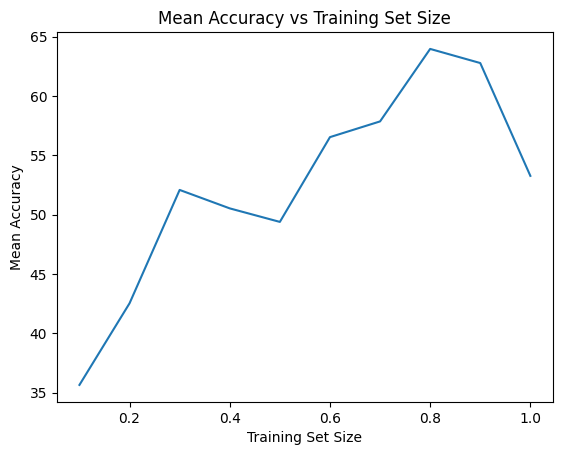

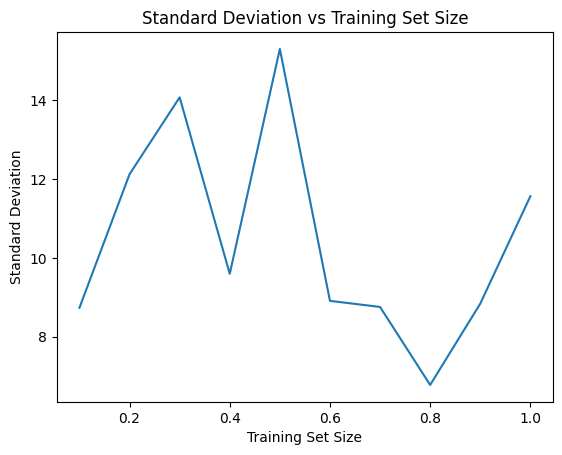

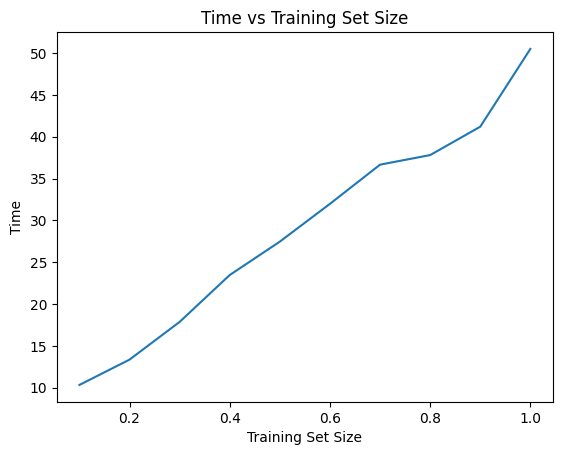

In [88]:
timesOcrArr = []
meanAccOcrArr = []
stdAccOcrArr = []
for n in training_sets:
    print(f'Training set size: {n*100:.0f}%')
    meanAccOcr, stdAccOcr, timeOcr, model = OneNNSet(X_train_Ocr, Y_train_Ocr, X_valid_Ocr, Y_valid_Ocr, 0.01, 128, 10, 20, n)
    timesOcrArr.append(timeOcr)
    meanAccOcrArr.append(meanAccOcr)
    stdAccOcrArr.append(stdAccOcr)
    print("")

plt.plot(training_sets, meanAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time')
plt.title('Time vs Training Set Size')
plt.show()


In [68]:
# Initialize and train Custom Perceptron for OCR
ocr_NN = TwoLayerNN(input_size=784,hidden_size=128, output_size=10)
ocr_NN.fit(X_train, Y_train, 20,0.01)

# Predict and evaluate
ocr_predictions = []
for i in range(X_valid.shape[0]):
    ocr_predictions.append(ocr_NN.predict(X_valid[i]))
#ocr_predictions = ocr_NN.predict(X_valid)
print(ocr_predictions[0:100])
CorrectPredictionCount = 0
for i in range(len(ocr_predictions)):
    if ocr_predictions[i] == Y_valid[i]:
        CorrectPredictionCount += 1
Ocr_Accuracy = CorrectPredictionCount/len(ocr_predictions)
print(f'OCR Accuracy: {Ocr_Accuracy * 100:.2f}%')

Iteration:  0 Accuracy:  0.1576
Iteration:  1 Accuracy:  0.3952
Iteration:  2 Accuracy:  0.5462
Iteration:  3 Accuracy:  0.6118
Iteration:  4 Accuracy:  0.6942
Iteration:  5 Accuracy:  0.7348
Iteration:  6 Accuracy:  0.7534
Iteration:  7 Accuracy:  0.7676
Iteration:  8 Accuracy:  0.7682
Iteration:  9 Accuracy:  0.7924
Iteration:  10 Accuracy:  0.775
Iteration:  11 Accuracy:  0.8004
Iteration:  12 Accuracy:  0.7814
Iteration:  13 Accuracy:  0.801
Iteration:  14 Accuracy:  0.802
Iteration:  15 Accuracy:  0.78
Iteration:  16 Accuracy:  0.761
Iteration:  17 Accuracy:  0.6592
Iteration:  18 Accuracy:  0.6924
Iteration:  19 Accuracy:  0.7124
[7, 3, 1, 0, 4, 1, 4, 8, 2, 7, 3, 2, 9, 8, 1, 3, 9, 7, 3, 4, 9, 8, 7, 8, 4, 0, 7, 4, 3, 1, 3, 1, 3, 4, 7, 2, 7, 1, 3, 1, 1, 7, 4, 8, 3, 3, 3, 2, 4, 4, 3, 3, 3, 3, 2, 8, 4, 1, 9, 7, 7, 8, 8, 8, 7, 8, 7, 4, 3, 3, 7, 3, 3, 8, 1, 7, 3, 7, 8, 7, 9, 2, 2, 7, 8, 4, 7, 3, 4, 1, 3, 8, 8, 3, 1, 4, 3, 8, 2, 9]
OCR Accuracy: 54.40%


Face Detection

In [69]:
FacetrainImg = "facedata/facedatatrain"
FacetrainLabel = "facedata/facedatatrainlabels"
FacevalidImg = "facedata/facedatavalidation"
FacevalidLabel = "facedata/facedatavalidationlabels"
FacetestImg = "facedata/facedatatest"
FacetestLabel = "facedata/facedatatestlabels"

X_train, Y_train = face_raw_data(FacetrainImg, FacetrainLabel)
X_train = X_train[:int(X_train.shape[0]*1.0), :]
Y_train = Y_train[:int(len(Y_train)*1.0)]

X_valid, Y_valid = face_raw_data(FacevalidImg, FacevalidLabel)
X_valid = X_valid[:int(X_valid.shape[0]*1.0), :]
Y_valid = Y_valid[:int(len(Y_valid)*1.0)]

X_test, Y_test = face_raw_data(FacetestImg, FacetestLabel)
X_test = X_test[:int(X_test.shape[0]*1.0), :]
Y_test = Y_test[:int(len(Y_test)*1.0)]

print(X_train.shape)
print(len(Y_train))
print(X_valid.shape)
print(len(Y_valid))
print(X_test.shape)
print(len(Y_test))

(451, 4200)
451
(301, 4200)
301
(150, 4200)
150


In [72]:
face_nn = TwoLayerNN(input_size=70*60, hidden_size=128, output_size=2)
face_nn.fit(X_train, Y_train, 20, 0.01)

face_predictions = []
for i in range(X_valid.shape[0]):
    face_predictions.append(face_nn.predict(X_valid[i]))
print(face_predictions[0:100])
CorrectPredictionCount = 0
for i in range(len(face_predictions)):
    if face_predictions[i] == Y_valid[i]:
        CorrectPredictionCount += 1
Face_Accuracy = CorrectPredictionCount/len(face_predictions)
print(f'Face Accuracy: {Face_Accuracy * 100:.2f}%')

Iteration:  0 Accuracy:  0.5033259423503326
Iteration:  1 Accuracy:  0.5188470066518847
Iteration:  2 Accuracy:  0.565410199556541
Iteration:  3 Accuracy:  0.5587583148558758
Iteration:  4 Accuracy:  0.5875831485587583
Iteration:  5 Accuracy:  0.6075388026607539
Iteration:  6 Accuracy:  0.6252771618625277
Iteration:  7 Accuracy:  0.6407982261640798
Iteration:  8 Accuracy:  0.6740576496674058
Iteration:  9 Accuracy:  0.6740576496674058
Iteration:  10 Accuracy:  0.7006651884700665
Iteration:  11 Accuracy:  0.6940133037694013
Iteration:  12 Accuracy:  0.7272727272727273
Iteration:  13 Accuracy:  0.7117516629711752
Iteration:  14 Accuracy:  0.7472283813747228
Iteration:  15 Accuracy:  0.753880266075388
Iteration:  16 Accuracy:  0.7583148558758315
Iteration:  17 Accuracy:  0.7694013303769401
Iteration:  18 Accuracy:  0.7738359201773836
Iteration:  19 Accuracy:  0.802660753880266
[array([1, 1]), array([0, 1]), array([0, 0]), array([0, 0]), array([0, 0]), array([0, 1]), array([1, 0]), array([

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()